# Apr ??, 2022 ()

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

## Entropy with log(k) / log(5)

In [6]:
from matplotlib.pyplot import text as mp_txt
set_style()

In [7]:
num = 100
bins = np.linspace(-1 / num, 1.0, num + 2)
xs = (bins[1:] + bins[:-1]) / 2
xs[0] = 0

In [8]:
i, j, k = gr_bold.run_h.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}


h_bold = cut_data(
    data=gr_bold.run_h.reshape(-1, 1, 174),
    bins=bins,
    oc_only=True,
)[0].reshape(i, j, k, -1)
h_bold_avg = bn.nanmean(bn.nanmean(bn.nanmean(h_bold, 2), 1), 0)

boot = bootstrap(
    x=h_bold,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_bold = bn.nanstd(boot, 0, ddof=1)


h_ca = cut_data(
    data=gr_ca.run_h.reshape(-1, 1, 174),
    bins=bins,
    oc_only=True,
)[0].reshape(i, j, k, -1)
h_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 2), 1), 0)

boot = bootstrap(
    x=h_ca,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

In [9]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)

In [10]:
h_bold = sp_stats.entropy(gr_bold.grp_pi_prune) / np.log(gr_bold.num_k)
h_ca = sp_stats.entropy(gr_ca.grp_pi_prune) / np.log(gr_ca.num_k)

hr_bold = sp_stats.rankdata(h_bold)
hr_ca = sp_stats.rankdata(h_ca)


h_thres = -np.inf
hpb = gr_bold.project_vec(h_bold, thres=h_thres, add_disjoint=False)
hpc = gr_ca.project_vec(h_ca, thres=h_thres, add_disjoint=False)

hrpb = gr_bold.project_vec(hr_bold, thres=h_thres, add_disjoint=False)
hrpc = gr_ca.project_vec(hr_ca, thres=h_thres, add_disjoint=False)


trb = gr_bold.trim2d(hrpb)
trc = gr_bold.trim2d(hrpc)

In [11]:
def _add_line(ax, text=False):
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=1.2)
        if text:
            mp_txt(
                x=x + 0.005,
                y=100 if i == 1 else 56,
                s=f"$\log({i}) \,\,/\,\, \log(5)$",
                fontsize=14,
                rotation=270,
                va='top',
            )
        x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
        ax.axvline(x, color='magenta', ls='-.', lw=1.5)

In [13]:
save_dir = pjoin(fig_dir, 'entropy')
os.makedirs(save_dir, exist_ok=True)

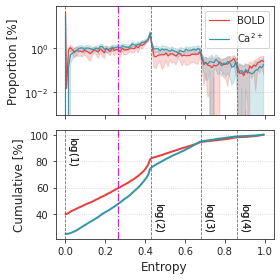

In [18]:
fig, axes = create_figure(2, 1, figsize=(4, 4), sharex='col')

data2p = {'BOLD': h_bold_avg, r'Ca$^{2+}$': h_ca_avg}
ax = axes[0]
for (lbl, y), color in zip(data2p.items(), [pal['bold-lite'], pal['ca2']]):
    lo = y - se_ca * t
    hi = y + se_ca * t
    ax.plot(xs, y, color=color, lw=1.2, label=lbl)
    ax.plot(xs, lo, color=color, lw=0.1, alpha=0.1)
    ax.plot(xs, hi, color=color, lw=0.1, alpha=0.1)
    ax.fill_between(xs, lo, hi, color=color, alpha=0.2)
ax.set_ylabel('Proportion [%]', fontsize=12)
ax.set_yscale('log')
ax.grid(axis='y')
ax.legend()

ax = axes[1]
ax.plot(xs, np.cumsum(h_bold_avg), lw=2, color=pal['bold-lite'])
ax.plot(xs, np.cumsum(h_ca_avg), lw=2, color=pal['ca2'])
ax.set_ylabel('Cumulative [%]', fontsize=12)

for ax in axes.flat:
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
        mp_txt(
            x=x + 0.005,
            y=100 if i == 1 else 50,
            s=f"$\log({i})$",
            fontsize=10,
            rotation=270,
            va='top',
        )

    x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
    ax.axvline(x, color='magenta', ls='-.', lw=1.2)
ax.grid(axis='y')
ax.set_xlabel('Entropy', fontsize=12)

name = 'ent-hist'
figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

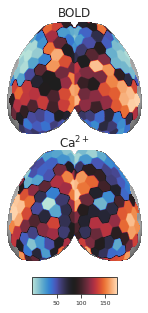

In [33]:
fig = plt.figure(figsize=(4, 5), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1.5, 1.0], height_ratios=[1, 1, 0.15])

ax = fig.add_subplot(gs[0, :])
x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
ax.imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
ax.imshow(x2p, cmap='icefire', interpolation='antialiased')
ax.set_title('BOLD', fontsize=12, y=0.99)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, :])
x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
ax.imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
im = ax.imshow(x2p, cmap='icefire', interpolation='antialiased')
ax.set_title(r'Ca$^{2+}$', fontsize=12, y=0.96)
remove_ticks(ax)

cax = fig.add_subplot(gs[2, 1])
plt.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(labelsize=6) 

name = 'ent-ctx-4by5'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

### What about anim h?

In [223]:
num = 20
bins = np.linspace(-1 / num, 1.0, num + 2)
xs = (bins[1:] + bins[:-1]) / 2
xs[0] = 0

<AxesSubplot:ylabel='Count'>

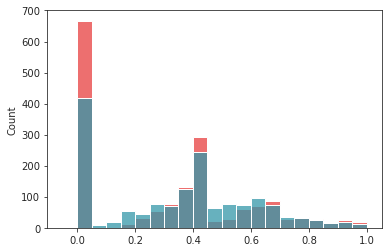

In [224]:
sns.histplot(gr_bold.anim_h.ravel(), bins=bins, color=pal['bold-lite'])
sns.histplot(gr_ca.anim_h.ravel(), bins=bins, color=pal['ca2'])

In [225]:
i, j, k = gr_bold.run_h.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

h_bold = cut_data(
    data=np.expand_dims(gr_bold.anim_h, 1),
    bins=bins,
    oc_only=True,
)[0].squeeze()
h_bold_avg = bn.nanmean(h_bold, 0)

boot = bootstrap(
    x=gr_bold.run_pi_prune,
    n_resamples=int(1e3),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = cut_data(
    data=boot,
    bins=bins,
    oc_only=True,
)[0].squeeze()
boot = bn.nanmean(boot, 1)
se_bold = bn.nanstd(boot, 0, ddof=1)


h_ca = cut_data(
    data=np.expand_dims(gr_ca.anim_h, 1),
    bins=bins,
    oc_only=True,
)[0].squeeze()
h_ca_avg = bn.nanmean(h_ca, 0)

boot = bootstrap(
    x=gr_ca.run_pi_prune,
    n_resamples=int(1e3),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = cut_data(
    data=boot,
    bins=bins,
    oc_only=True,
)[0].squeeze()
boot = bn.nanmean(boot, 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

In [226]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)

In [230]:
save_dir = pjoin(fig_dir, 'entropy')
os.makedirs(save_dir, exist_ok=True)

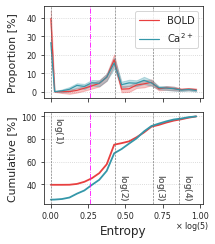

In [242]:
fig, axes = create_figure(2, 1, figsize=(3.1, 3.5), sharex='col')

data2p = {'BOLD': h_bold_avg, r'Ca$^{2+}$': h_ca_avg}
ax = axes[0]
for (lbl, y), color in zip(data2p.items(), [pal['bold-lite'], pal['ca2']]):
    lo = y - se_ca * t
    hi = y + se_ca * t
    ax.plot(xs, y, color=color, lw=1.2, label=lbl)
    # ax.plot(xs, lo, color=color, lw=0.1, alpha=0.1)
    # ax.plot(xs, hi, color=color, lw=0.1, alpha=0.1)
    ax.fill_between(xs, lo, hi, color=color, alpha=0.3)
ax.set_ylabel('Proportion [%]', fontsize=11, labelpad=8.5)
ax.tick_params(axis='y', labelsize=8)
# ax.set_yscale('log')
ax.grid(axis='y')
ax.legend(loc='upper right', fontsize=10)

ax = axes[1]
ax.plot(xs, np.cumsum(h_bold_avg), lw=1.8, color=pal['bold-lite'])
ax.plot(xs, np.cumsum(h_ca_avg), lw=1.8, color=pal['ca2'])
ax.set_ylabel('Cumulative [%]', fontsize=11)

for ax in axes.flat:
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=0.6)
        mp_txt(
            x=x + 0.01,
            y=100 if i == 1 else 50,
            s=f"$\log({i})$",
            fontsize=9,
            rotation=270,
            color='dimgrey',
            va='top',
        )

    x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
    ax.axvline(x, color='magenta', ls='-.', lw=0.8)
ax.grid(axis='y')
ax.set_xlabel('Entropy', fontsize=12)

ax.tick_params(axis='both', labelsize=8)
mp_txt(
    x=0.83,
    y=1,
    s=r"$\times \,\, \log(5)$",
    fontsize=8,
)

name = 'ent-hist-anim'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

plt.show()

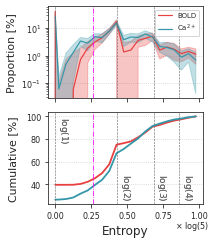

In [243]:
fig, axes = create_figure(2, 1, figsize=(3.1, 3.5), sharex='col')

data2p = {'BOLD': h_bold_avg, r'Ca$^{2+}$': h_ca_avg}
ax = axes[0]
for (lbl, y), color in zip(data2p.items(), [pal['bold-lite'], pal['ca2']]):
    lo = y - se_ca * t
    hi = y + se_ca * t
    ax.plot(xs, y, color=color, lw=1.2, label=lbl)
    # ax.plot(xs, lo, color=color, lw=0.1, alpha=0.1)
    # ax.plot(xs, hi, color=color, lw=0.1, alpha=0.1)
    ax.fill_between(xs, lo, hi, color=color, alpha=0.3)
ax.set_ylabel('Proportion [%]', fontsize=11)
ax.tick_params(axis='y', labelsize=8)
ax.set_yscale('log')
ax.grid(axis='y')
ax.legend(loc='upper right', fontsize=7)

ax = axes[1]
ax.plot(xs, np.cumsum(h_bold_avg), lw=1.8, color=pal['bold-lite'])
ax.plot(xs, np.cumsum(h_ca_avg), lw=1.8, color=pal['ca2'])
ax.set_ylabel('Cumulative [%]', fontsize=11, labelpad=8.)

for ax in axes.flat:
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=0.6)
        mp_txt(
            x=x + 0.01,
            y=100 if i == 1 else 50,
            s=f"$\log({i})$",
            fontsize=9,
            rotation=270,
            color='dimgrey',
            va='top',
        )

    x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
    ax.axvline(x, color='magenta', ls='-.', lw=0.8)
ax.grid(axis='y')
ax.set_xlabel('Entropy', fontsize=12)

ax.tick_params(axis='both', labelsize=8)
mp_txt(
    x=0.83,
    y=1,
    s=r"$\times \,\, \log(5)$",
    fontsize=8,
)

name = 'ent-hist-anim-log'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

plt.show()

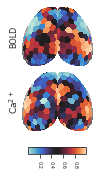

In [332]:
fig = plt.figure(figsize=(3, 2.7), constrained_layout=True)
gs = GridSpec(4, 3, width_ratios=[1, 1.3, 1], height_ratios=[1, 1, 0.05, 0.12])

ax = fig.add_subplot(gs[0, :])
x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = trb['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
ax.imshow(x2p, cmap='icefire', interpolation='none')#'antialiased')
ax.set_ylabel('BOLD', fontsize=8)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, :])
x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = trc['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
im = ax.imshow(x2p, cmap='icefire', interpolation='none')#'antialiased')
ax.set_ylabel(r'Ca$^{2+}$', fontsize=9, labelpad=2)
remove_ticks(ax)

cax = fig.add_subplot(gs[-1, 1])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
ticks = [0.2, 0.4, 0.6, 0.8]
cbar.set_ticks([e * len(gr_ca.n2l) for e in ticks])
cax.set_xticklabels(ticks)
cax.tick_params(labelsize=5, rotation=-90)

name = 'ent-ctx'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

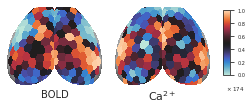

In [472]:
fig = plt.figure(figsize=(4., 3), constrained_layout=True)
gs = GridSpec(3, 3, height_ratios=[1.7, 3, 2], width_ratios=[1, 1, 0.08])

ax = fig.add_subplot(gs[:, 0])
x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = trb['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
ax.imshow(x2p, cmap='icefire', interpolation='none')#'antialiased')
ax.set_xlabel('BOLD', fontsize=10)
remove_ticks(ax)

ax = fig.add_subplot(gs[:, 1])
x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = trc['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
im = ax.imshow(x2p, cmap='icefire', interpolation='none')#'antialiased')
ax.set_xlabel(r'Ca$^{2+}$', fontsize=11)
remove_ticks(ax)

cax = fig.add_subplot(gs[1, -1])
cbar = plt.colorbar(im, cax=cax)
ticks = [0.2, 0.4, 0.6, 0.8]
cbar.set_ticks([1] + [e * len(gr_ca.n2l) for e in ticks] + [173.0])
cax.set_yticklabels([0.0] + ticks + [1.0])
cax.tick_params(labelsize=5)

mp_txt(
    x=70,
    y=-40,
    s=r"$\times \,\, 174$",
    fontsize=5.5,
)

name = 'ent-ctx-horiz'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

## Carto

### Animal

In [5]:
gr_ca.anim_deg = bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1)
gr_bold.anim_deg = bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1)

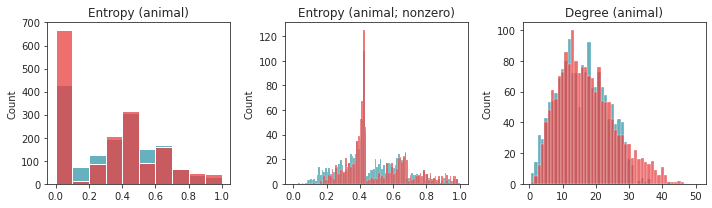

In [6]:
fig, axes = create_figure(1, 3, (10, 3), 'col')
sns.histplot(gr_ca.anim_h[np.isfinite(gr_ca.anim_h)],
             bins=np.linspace(0, 1.0, 11), color=pal['ca2'], ax=axes[0])
sns.histplot(gr_bold.anim_h[np.isfinite(gr_bold.anim_h)],
             bins=np.linspace(0, 1.0, 11), color=pal['bold-lite'], ax=axes[0])
axes[0].set_title('Entropy (animal)')

sns.histplot(gr_ca.anim_h[gr_ca.anim_h.nonzero()],
             bins=np.linspace(0, 1.0, 101), color=pal['ca2'], ax=axes[1])
sns.histplot(gr_bold.anim_h[gr_bold.anim_h.nonzero()],
             bins=np.linspace(0, 1.0, 101), color=pal['bold-lite'], ax=axes[1])
axes[1].set_title('Entropy (animal; nonzero)')

sns.histplot(gr_ca.anim_deg[np.isfinite(gr_ca.anim_deg)],
             bins=np.linspace(0.5, 50.5, 51), color=pal['ca2'], ax=axes[2])
sns.histplot(gr_bold.anim_deg[np.isfinite(gr_bold.anim_deg)],
             bins=np.linspace(0.5, 50.5, 51), color=pal['bold-lite'], ax=axes[2])
axes[2].set_title('Degree (animal)')

plt.show()

In [7]:
affil, affil_included = gr_ca.node_affiliations()

In [8]:
dlist = []
for i in range(10):
    dlist.append({
        'mode': ['ca2'] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_ca.anim_h[i],
        'Degree': gr_ca.anim_deg[i],
    })
    dlist.append({
        'mode': ['bold-lite'] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_bold.anim_h[i],
        'Degree': gr_bold.anim_deg[i],
    })
df = pd.DataFrame(merge_dicts(dlist))

In [9]:
vlines = [(0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)]
vlines += [np.log(i) / np.log(5) for i in range(2, 5)]
hlines = [15]

In [10]:
selected = ['Prefrontal', 'Somatomotor', 'Visual', 'Medial']

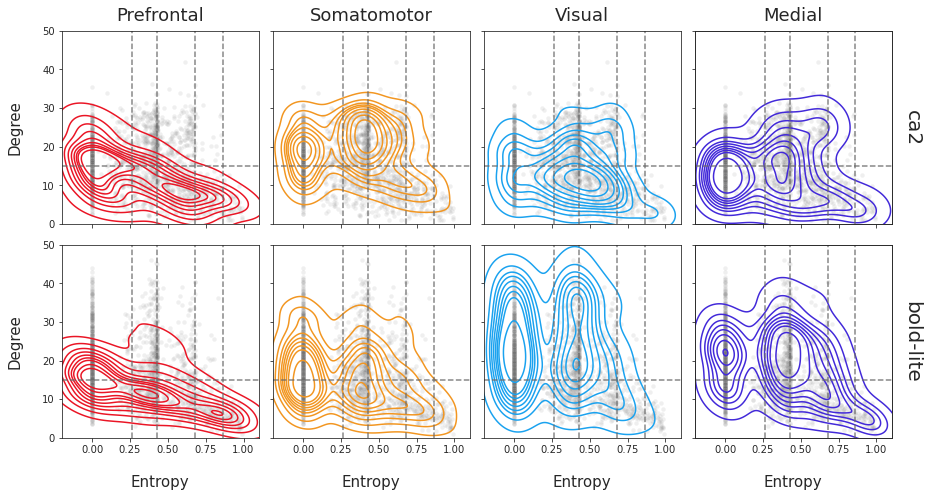

In [11]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', alpha=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', alpha=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=20,
            alpha=0.1,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
ax.set_ylim((0, 50))
ax.set_xlim((-0.2, 1.1))

plt.show()

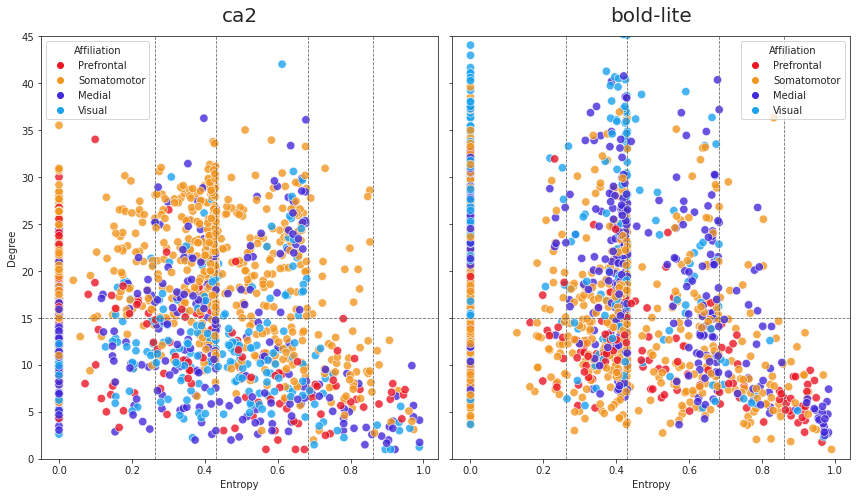

In [12]:
fig, axes = create_figure(1, 2, (12, 7), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8)
        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=70,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(mode, fontsize=20, y=1.02)
ax.set_ylim((0, 45))

plt.show()

In [13]:
vlines = [(0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)]
vlines += [np.log(i) / np.log(5) for i in range(2, 5)]
hlines = [np.nanquantile(np.concatenate([gr_bold.run_deg, gr_ca.run_deg]), _q) for _q in [0.50, 0.75]]

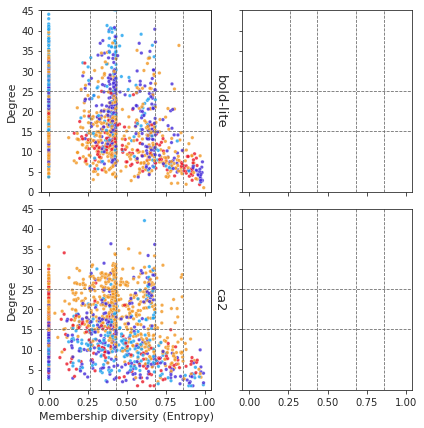

In [14]:
fig, axes = create_figure(2, 2, (6, 6), 'all', 'all')
for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8)

for ax, (mode, c) in zip(axes[:, 0].flat, sorted(pal.items())):        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=12,
        alpha=0.8,
        ax=ax,
        legend=False,
    )
    ax.set_ylabel('Degree', fontsize=11)
    if mode == 'ca2':
        ax.set_xlabel('Membership diversity (Entropy)', fontsize=11)
    axtw = ax.twinx()
    axtw.set_ylabel(mode, rotation=-90, fontsize=13, labelpad=15, loc='center')
    axtw.set_yticks([])
ax.set_ylim((0, 45))
name = f'carto-run'
figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

In [15]:
cm_3 = sns.cubehelix_palette(
    n_colors=5,
    start=0,
    rot=0.1,
    gamma=1.0,
    hue=0.80,
    light=0.8,
    dark=0.4,
)
cm_3

In [16]:
cm_2 = sns.cubehelix_palette(
    n_colors=5,
    start=2.00,
    rot=0.1,
    gamma=1.0,
    hue=0.80,
    light=0.8,
    dark=0.4,
)
cm_2

In [17]:
cm_1 = sns.cubehelix_palette(
    n_colors=5,
    start=0.80,
    rot=0.1,
    gamma=1.0,
    hue=0.80,
    light=0.8,
    dark=0.4,
)
cm_1

In [18]:
cms = [cm_1, cm_3, cm_2]

In [135]:
ymax = 45
box_y = [0] + hlines + [45]
box_x = [0] + vlines + [1]

In [343]:
from matplotlib.pyplot import text as mp_txt

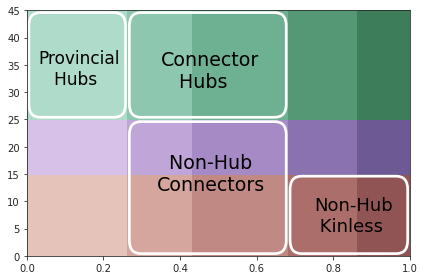

In [412]:
fig, ax = create_figure()
for i, xx in enumerate(box_x[:-1]):
    for j, yy in enumerate(box_y[:-1]):
        rect = matplotlib.patches.Rectangle(
            xy=(xx, yy),
            width=box_x[i + 1] - xx,
            height=box_y[j + 1] - yy,
            color=list(cms[j])[i],
        )
        ax.add_patch(rect)
ax.set_ylim(0, ymax)

looper = zip(
    [0, 1, 1, 3],
    [2, 2, 0, 0],
    [1, 2, 2, 2],
    [1, 1, 2, 1],
    [1] * 4,
)
for x, y, w, h, a in looper:
    patch = matplotlib.patches.FancyBboxPatch(
        xy=(box_x[x], box_y[y]),
        width=box_x[x + w] - box_x[x],
        height=box_y[y + h] - box_y[y],
        mutation_scale=1,
        mutation_aspect=80,
        boxstyle=matplotlib.patches.BoxStyle('round', pad=-0.005, rounding_size=0.03),
        facecolor='none',
        edgecolor='white',
        alpha=a,
        ls='-',
        lw=2.7,
    )
    ax.add_patch(patch)

text_dict = {
    'Provincial\n   Hubs': (0.03, 31.5, 17),
    'Connector\n   Hubs': (0.35, 31.0, 19),
    '  Non-Hub\nConnectors': (0.34, 12, 19),
    'Non-Hub\n Kinless': (0.75, 4.5, 18),
}
for s, (x, y, f) in text_dict.items():
    mp_txt(
        x=x,
        y=y,
        s=s,
        fontsize=f,
        rotation=0,
        color='k',
    )
    
    
plt.show()

In [ ]:

mp_txt(
    x=0.03,
    y=31.5,
    s='Provincial\n   Hubs',
    fontsize=17,
    rotation=0,
    color='k',
)
mp_txt(
    x=0.35,
    y=31,
    s='Connector\n   Hubs',
    fontsize=19,
    rotation=0,
    color='k',
)
mp_txt(
    x=0.34,
    y=12,
    s='  Non-Hub\nConnectors',
    fontsize=19,
    rotation=0,
    color='k',
)
mp_txt(
    x=0.75,
    y=4.5,
    s='Non-Hub\n Kinless',
    fontsize=18,
    rotation=0,
    color='k',
)
    

In [413]:
f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_flat = ants.image_read(f, pixeltype='unsigned int')
parcel_flat = parcel_flat.numpy()

f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_top = ants.image_read(f, pixeltype='unsigned int')
parcel_top = parcel_top.numpy()

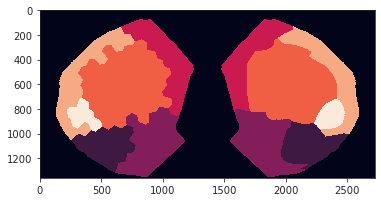

In [414]:
affil_max_flat = np.zeros_like(parcel_flat)
for r, af in affil['regions_affil_max'].items():
    affil_max_flat[parcel_flat == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_flat, affil['regions_r'])
affil_max_flat[m] = affil['obj_flat'][m]
affil_max_flat[parcel_flat == 0] = 0
plt.imshow(affil_max_flat);

In [415]:
regions_included = [
    mice.parcel.encode(1, int(lbl.split('-')[1]), 0)
    for lbl in gr_ca.l2n
]
regions_included = np.array(regions_included)
regions_included = regions_included[gr_ca.l_ids]

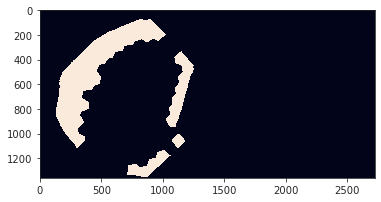

In [416]:
mask_f = np.zeros(parcel_flat.shape)
mask_f[np.isin(parcel_flat, affil['regions_l'])] = 1
mask_f[np.isin(parcel_flat, regions_included)] = 0
plt.imshow(mask_f);

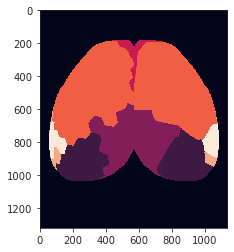

In [417]:
affil_max_top = np.zeros_like(parcel_top)
for r, af in affil['regions_affil_max'].items():
    affil_max_top[parcel_top == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_top, affil['regions_r'])
affil_max_top[m] = affil['obj_top'][m]
affil_max_top[parcel_top == 0] = 0
plt.imshow(affil_max_top);

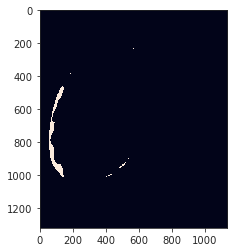

In [418]:
mask_t = np.zeros(parcel_top.shape)
mask_t[np.isin(parcel_top, affil['regions_l'])] = 1
mask_t[np.isin(parcel_top, regions_included)] = 0
plt.imshow(mask_t);

In [419]:
mf_tr, f_tr = filter_boundaries([mask_f, affil_max_flat], mask=affil_max_flat)
mt_tr, t_tr = filter_boundaries([mask_t, affil_max_top], mask=affil_max_top)

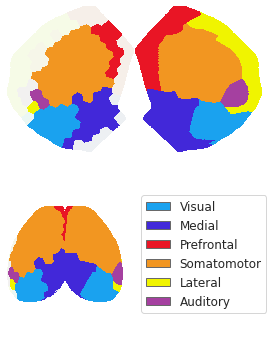

In [420]:
fig = plt.figure(figsize=(4, 5), tight_layout=True)
gs = GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
x2p = mwh(f_tr == 0, f_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mf_tr == 0, mf_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 0])
x2p = filter_boundaries(t_tr, t_tr)
x2p = mwh(x2p == 0, x2p)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mt_tr == 0, mt_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 1])
legend_elements = [
    matplotlib.patches.Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=12, loc='center')
remove_ticks(ax)

#### Boundary plots

In [421]:
from scipy import ndimage

<matplotlib.image.AxesImage object at 0x7fbf21208880>

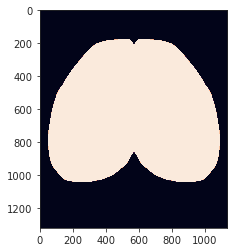

In [422]:
x = (parcel_top > 0).astype(float)
x = ndimage.gaussian_filter(x, sigma=1)
x = (x > 0).astype(float)
x = ndimage.gaussian_filter(x, sigma=0.5)
plt.imshow(x)

In [423]:
contour = ~np.logical_or(
    ndimage.sobel(x, axis=0),
    ndimage.sobel(x, axis=1),
)

<matplotlib.image.AxesImage object at 0x7fbf210fe490>

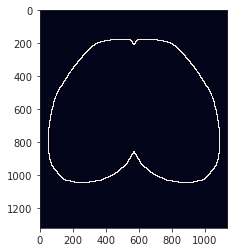

In [424]:
plt.imshow(contour == 0)

<matplotlib.image.AxesImage object at 0x7fbf2172b730>

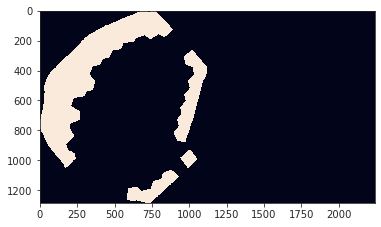

In [425]:
plt.imshow(mf_tr)

<matplotlib.image.AxesImage object at 0x7fbf21f93760>

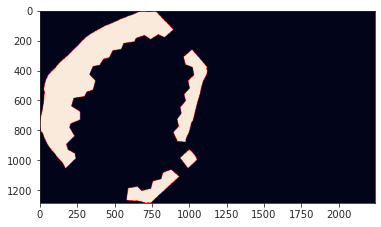

In [426]:
x = mf_tr.astype(float)
x = ndimage.gaussian_filter(x, sigma=2.5)
#x = (x > 0).astype(float)
#x = ndimage.gaussian_filter(x, sigma=1)
plt.imshow(x)

In [427]:
contour_f = np.logical_or(
    ndimage.sobel(x, axis=0),
    ndimage.sobel(x, axis=1),
)

<matplotlib.image.AxesImage object at 0x7fbf216e8d30>

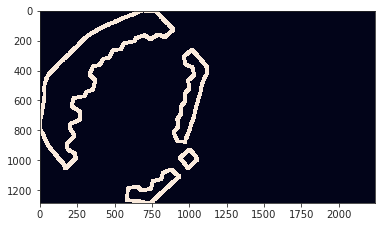

In [428]:
plt.imshow(contour_f)

<matplotlib.image.AxesImage object at 0x7fbf21120700>

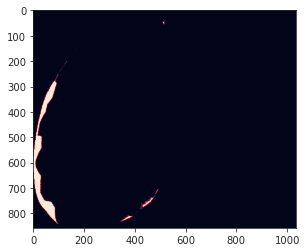

In [429]:
x = mt_tr.astype(float)
x = ndimage.gaussian_filter(x, sigma=1.5)
plt.imshow(x)

In [430]:
contour_t = np.logical_or(
    ndimage.sobel(x, axis=0),
    ndimage.sobel(x, axis=1),
)

<matplotlib.image.AxesImage object at 0x7fbf20b0da90>

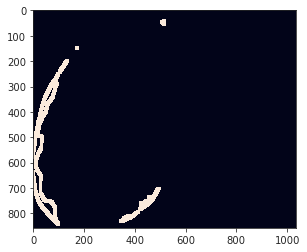

In [431]:
plt.imshow(contour_t)

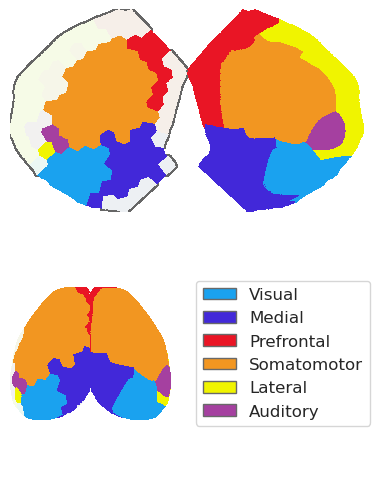

In [432]:
fig = plt.figure(figsize=(4, 5), tight_layout=True, dpi=100)
gs = GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.imshow(contour_f, cmap='Greys', interpolation='none', alpha=0.6)
x2p = mwh(f_tr == 0, f_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mf_tr == 0, mf_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
# x2p = mwh(contour == 1, contour)

remove_ticks(ax)

ax = fig.add_subplot(gs[1, 0])
x2p = filter_boundaries(t_tr, t_tr)
x2p = mwh(x2p == 0, x2p)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mt_tr == 0, mt_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 1])
legend_elements = [
    matplotlib.patches.Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=12, loc='center')
remove_ticks(ax)

In [433]:
save_dir = pjoin(fig_dir, 'carto')
os.makedirs(save_dir, exist_ok=True)

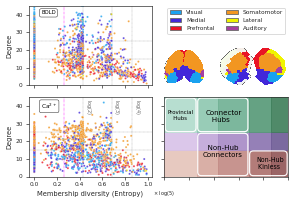

In [556]:
fig = plt.figure(figsize=(5, 3.5), tight_layout=True, dpi=60)
gs = GridSpec(4, 4, height_ratios=[0.8, 1] * 2, width_ratios=[1, 1.8] * 2)

for i, (mode, c) in enumerate(sorted(pal.items())):
    ax = fig.add_subplot(gs[2*i:2*(i+1), :2])
    for vi, x in enumerate(vlines):
        c = 'magenta' if vi == 0 else 'dimgrey'
        ls = '-.' if vi == 0 else '--'
        lw = 0.5 if vi == 0 else 0.3
        ax.axvline(x, color=c, ls=ls, lw=lw, zorder=0)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.3, alpha=1, zorder=0)
    
    _df = df.loc[
        (df['mode'] == mode) # &
        # (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=6,
        alpha=0.8,
        legend=False,
        ax=ax,
    )
    ax.set_ylabel('Degree', fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.set_ylim((0, 45))
    ax.annotate(
        text=r'Ca$^{2+}$' if mode == 'ca2' else 'BOLD',
        xy=(0.06, 42.5),
        fontsize=7 if mode == 'ca2' else 6.5,
        ha='left',
        va='top',
        color='k',
        bbox={'boxstyle': 'round,pad=0.3', 'fc': 'none', 'ec': 'k', 'lw': '.5'},
    )
    if mode == 'ca2':
        for i in range(2, 5):
            x = np.log(i) / np.log(5)
            mp_txt(
                x=x + 0.004,
                y=44,
                s=f"$\log({i})$",
                fontsize=6,
                rotation=270,
                color='dimgrey',
                va='top',
            )
        ax.set_xlabel('Membership diversity (Entropy)', fontsize=8)
        xticks = ax.get_xticks()
        xlim = ax.get_xlim()
    else:
        ax.tick_params(axis='x', labelbottom=False)
        ax.set_xlabel('')
    yticks = ax.get_yticks()

ax = fig.add_subplot(gs[1, 3])
ax.imshow(contour_f, cmap='Greys', interpolation='none', alpha=0.6)
x2p = mwh(f_tr == 0, f_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mf_tr == 0, mf_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
# x2p = mwh(contour == 1, contour)

remove_ticks(ax)

ax = fig.add_subplot(gs[1, 2])
ax.imshow(contour_t, cmap='Greys', interpolation='none', alpha=0.6)
# x2p = filter_boundaries(t_tr)
x2p = mwh(t_tr == 0, t_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mt_tr == 0, mt_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[0, 2:])
legend_elements = [
    matplotlib.patches.Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=7, ncol=2, loc='center')
remove_ticks(ax)
    # axtw = ax.twinx()
    # axtw.set_ylabel(mode, rotation=-90, fontsize=13, labelpad=15, loc='center')
    # axtw.set_yticks([])

ax = fig.add_subplot(gs[2:, 2:])
# for vi, x in enumerate(vlines):
  #   c = 'magenta' if vi == 0 else 'dimgrey'
  #   ls = '-.' if vi == 0 else '--'
   #  lw = 0.5 if vi == 0 else 0.4
   #  ax.axvline(x, color=c, ls=ls, lw=lw)
# for y in hlines:
    # ax.axhline(y, color='dimgrey', ls='--', lw=0.4)
for i, xx in enumerate(box_x[:-1]):
    for j, yy in enumerate(box_y[:-1]):
        rect = matplotlib.patches.Rectangle(
            xy=(xx, yy),
            width=box_x[i + 1] - xx,
            height=box_y[j + 1] - yy,
            color=list(cms[j])[i],
            alpha=0.9,
        )
        ax.add_patch(rect)

looper = zip(
    [0, 1, 1, 3],
    [2, 2, 0, 0],
    [1, 2, 2, 2],
    [1, 1, 2, 1],
    [1] * 4,
)
for x, y, w, h, a in looper:
    patch = matplotlib.patches.FancyBboxPatch(
        xy=(box_x[x], box_y[y]),
        width=box_x[x + w] - box_x[x],
        height=box_y[y + h] - box_y[y],
        mutation_scale=1,
        mutation_aspect=68,
        boxstyle=matplotlib.patches.BoxStyle('round', pad=-0.007, rounding_size=0.03),
        facecolor='none',
        edgecolor='white',
        alpha=a,
        ls='-',
        lw=1.4,
    )
    ax.add_patch(patch)

text_dict = {
    'Provincial\n   Hubs': (0.027, 32, 6.5),
    'Connector\n   Hubs': (0.33, 31.0, 8.5),
    '  Non-Hub\nConnectors': (0.31, 11.3, 8.5),
    'Non-Hub\n Kinless': (0.745, 4.4, 7.5),
}
for s, (x, y, f) in text_dict.items():
    mp_txt(
        x=x,
        y=y,
        s=s,
        fontsize=f,
        rotation=0,
        color='k',
    )
ax.set_xlabel(r"$\times \,\, \log(5)$", fontsize=6, x=-.002, labelpad=15)
# mp_txt(
#     x=-0.1,
#     y=-10,
#     s=r"$\times \,\, \log(5)$",
#     fontsize=8,
# )
        
# ax.set_xlabel('Membership diversity (Entropy)', fontsize=8)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=False)
ax.set_xlim((0, 1))
ax.set_ylim((0, 45))

name = f'carto-run'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

### Group

In [135]:
num = len(gr_ca.grp_h.flat)
gr_ca.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1), 0)
gr_bold.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1), 0)

In [136]:
df = pd.DataFrame({
    'mode': ['ca2'] * num + ['bold-lite'] * num,
    'Degree': list(gr_ca.grp_deg.flat) + list(gr_bold.grp_deg.flat),
    'Entropy': list(gr_ca.grp_h.flat) + list(gr_bold.grp_h.flat),
    'Affiliation': affil_included * 2,
})

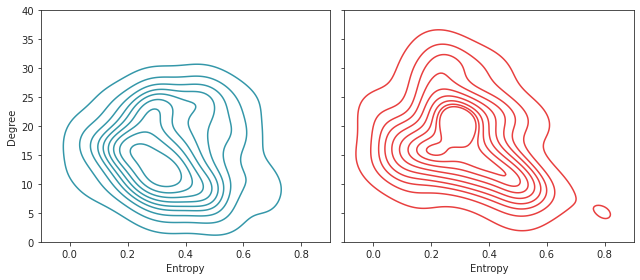

In [137]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        # cmap='mako' if mode == 'ca2' else 'rocket',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))
plt.show()

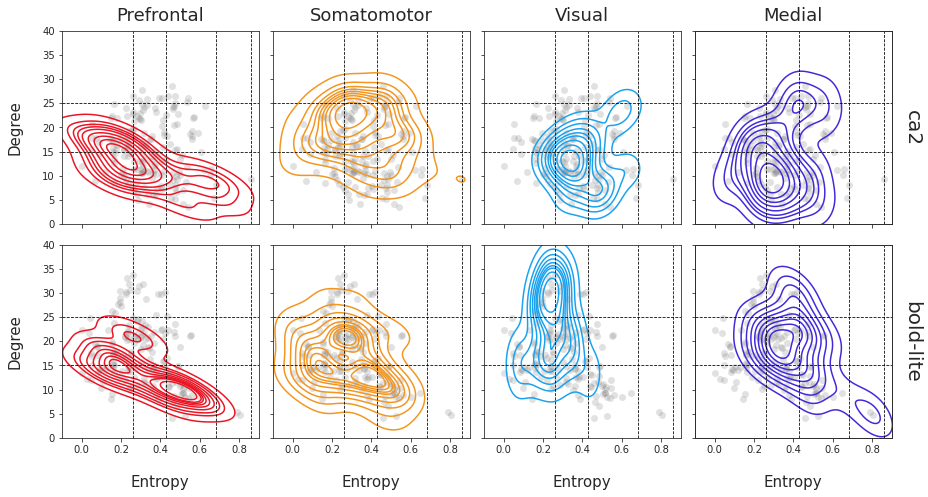

In [138]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='k', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='k', ls='--', lw=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=50,
            alpha=0.2,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
            # axtw.yaxis.set_label_position("right")
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))

plt.show()

In [139]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 15.0), (0, 0.26264392340968856)),
    '01': ((0, 15.0), (0.26264392340968856, 0.43067655807339306)),
    '02': ((0, 15.0), (0.43067655807339306, 0.6826061944859854)),
    '03': ((0, 15.0), (0.6826061944859854, 0.8613531161467861)),
    '04': ((0, 15.0), (0.8613531161467861, 1)),
    '10': ((15.0, 25.0), (0, 0.26264392340968856)),
    '11': ((15.0, 25.0), (0.26264392340968856, 0.43067655807339306)),
    '12': ((15.0, 25.0), (0.43067655807339306, 0.6826061944859854)),
    '13': ((15.0, 25.0), (0.6826061944859854, 0.8613531161467861)),
    '14': ((15.0, 25.0), (0.8613531161467861, 1)),
    '20': ((25.0, 100), (0, 0.26264392340968856)),
    '21': ((25.0, 100), (0.26264392340968856, 0.43067655807339306)),
    '22': ((25.0, 100), (0.43067655807339306, 0.6826061944859854)),
    '23': ((25.0, 100), (0.6826061944859854, 0.8613531161467861)),
    '24': ((25.0, 100), (0.8613531161467861, 1))
}

In [140]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.grp_h, gr_ca.grp_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.grp_deg, gr_ca.grp_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = cond.astype(float)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)